# PS5: The Apples Versus Oranges Problem as a Markov Decision Process
Problem set 5 (PS5) tests the hypothesis that a classical optimization problem, such as selecting the optimal consumption bundle of apples and oranges, can be structured as a Markov Decision Process (MDP), where an optimal policy can be computed using value iteration. Toward this objective, there are two problems that we need to solve:

* __Problem 1__: In this problem, we solve the apples and oranges problem subject to a budget constraint as a nonlinear programming problem [using the `MadNLP.jl` package](https://github.com/MadNLP/MadNLP.jl). The optimal solution to this problem will be used as the terminal state for the MDP calculations.
* __Problem 2__: In this problem, we construct an MDP problem encoding the apples and oranges decision and solve for the optimal policy function $\pi$ using value iteration. In this problem, we enforce the budget constraint as a soft-wall constraint and use reward shaping to help the search.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [75]:
include("Include-student.jl");

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Helper Function: Cobb-Douglas Utility

We need a utility function to evaluate the desirability of different combinations of apples and oranges. The utility function `U(...)` computes the utility of combinations of apples and oranges using a Cobb-Douglas utility model. A tuple holding the number of `(apples, oranges)`, i.e., the combinations of objects we are searching over, and the $\alpha$-vector (preferences) are passed as arguments; the `utility` value is returned.

In [76]:
function U(x::Tuple{Int,Int}, α::Array{Float64,1})::Float64
    
    # get the apples, and oranges 
    apples = x[1];
    oranges = x[2];
    
    # compute the objective -
    utility = (apples^α[1])*(oranges^α[2]);
    
    # return -
    return utility;
end;

___

## Problem 1: Compute the optimal number of Apples and Oranges to purchase
In this problem, we compute the optimal number of apples and oranges to purchase given a budget constraint using nonlinear programming, i.e., we maximize the utility function subject to the budget constraint.

### Problem Statement
Use a Cobb-Douglas utility function combined with a budget constraint to compute the optimal combination of apples and oranges that gives the maximum utility for the available budget. The Cobb-Douglas utility function for a collection of objects $x_{1},\cdots,x_{n}$ is given by:
$$
\begin{align*}
\text{maximize } U(x_{1},\cdots,x_{n}) &= \prod_{i=1}^{n}x_{i}^{\alpha_{i}}\\
\text{subject to } \sum_{i=1}^{n}p_{i}x_{i} &\leq B\\
x_{i} &\geq 0, \quad i=1,\cdots,n
\end{align*}
$$
where the $\alpha_{i}\geq{0}$ parameters are preference coefficients associated with each object, $p_{i}$ is the unit price of object $i$, $x_{i}$ are the quantities of each object, and $B$ is the total budget available for purchasing the objects.

> __Setup__:
>
> For this problem, let's assume we have the following parameters:
> * The preference coefficient vector $\alpha = (0.55,0.45)$ and the total budget $B$ = `50 USD`
> * The unit price of an `apple` is `0.98 USD` and the unit price of an `orange` is `1.49 USD`
> * Let `apples` be index `1` and `oranges` be index `2`
> * Assume the bounds run from `0` to $B/p_i$ for each good $i$ and the initial guess is `0.1*ones(2)`.

We'll use [the `build(...)` method](src/Factory.jl) to construct an instance of [the `MySimpleCobbDouglasChoiceProblem` type](src/Types.jl) holding the parameters in the `base` variable. We'll then pass `base` to [the `mysolve(...)` function](src/Compute.jl) and set the return to the variable `base_solution`.

In [77]:
base_solution, α, c, B = let 

    # initialize -
    α = [0.55, 0.45]; # coefficients
    c = [0.98, 1.49]; # price of x1 and x2
    total_budget = 50.0; # how much money we have to spend
    base_solution = nothing;

    # define bounds: 2×2 matrix where bounds[i,:] = [lower_bound, upper_bound]
    bounds = [0.0  total_budget/c[1];    # good 1 (apples): from 0 to max affordable
              0.0  total_budget/c[2]]    # good 2 (oranges): from 0 to max affordable

    # define initial guess: warm-start for optimizer
    initial = 0.1 .* ones(2)

    # build my problem object using factory (use field names matching Types.jl) -
    model = build(MySimpleCobbDouglasChoiceProblem, (α=α, c=c, I=total_budget, bounds=bounds, initial=initial));

    # call the solve function. This will return a dictionary with data about the solution
    base_solution = mysolve(model);
    
    # return -
    base_solution, α, c, total_budget;
end;

This is MadNLP version v0.8.12, running with umfpack

Number of nonzeros in constraint Jacobian............:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du inf_compl lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 0.00e+00 4.71e-01 5.09e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1 -2.4856725e-01 1.22e-15 3.45e-01 1.78e+01  -1.0 3.64e-

In [78]:
base_solution

Dict{String, Any} with 3 entries:
  "argmax"          => [28.0612, 15.1007]
  "budget"          => 50.0
  "objective_value" => 21.2328

What is the optimal combination of apples and oranges?

In [79]:
optimal_apples = base_solution["argmax"][1] |> x-> round(x,digits=0) |> Int
optimal_oranges = base_solution["argmax"][2] |> x-> round(x,digits=0) |> Int
println("Optimal: (apples, oranges) = ($(optimal_apples),$(optimal_oranges))")

Optimal: (apples, oranges) = (28,15)


___

## Problem 2: Solve the Apples and Oranges problem as an MDP
Now, we solve the apples versus oranges problem as a Markov Decision Process (MDP). 

> __What are we going to do?__ 
>
> Here are the subtasks associated with solving the apples versus oranges problem as an MDP:
> * __Task 1__: Set up a $30\times{30}$ grid, encoded as an instance of the `MyRectangularGridWorldModel` type.
>   * `TODO`: Add a terminal state at the optimal combination of apples and oranges computed from Problem 1. Set the reward for this state as the optimal _integer_ fitness value calculated using the `U(...)` function defined above.
>   * `TODO`: Add the optimal combination of apples and oranges computed from Problem 1 to the `absorbing_state_set`.
> * __Task 2__: Use your `MyRectangularGridWorldModel` instance to generate the components of the MDP, namely, the reward function (or array) $R(s, a)$ and the model of the physics of the world in the transition function (or array) $T(s, s^{\prime}, a)$.
>    * `TODO`: Modify the $R[s,a]$ array code from lecture `L11d` so that it uses the `U(...)` function for its values. This is a type of reward shaping, as we use the utility function model to give the agent some hints along the way.
>    * `TODO`: Modify the $R[s,a]$ array to describe a _soft wall_, i.e., a region where the budget constraint is violated. Unlike a hard wall that makes states unreachable, a soft wall assigns a penalty but still allows the agent to explore these states. Set the wall penalty as `-1000` and allow up to a `1 USD` violation of the budget constraint before applying the penalty.
> * __Task 3__: Use value iteration to estimate the optimal value function $U^{\star}(s)$. 
>    * `TODO`: For your choice of the $(\gamma,k_{\max},\epsilon)$ hyperparameters, extract the action-value function $Q(s, a)$ from the optimal value function $U^{\star}(s)$ and compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$.

Let's implement these tasks step by step.

### Task 1: Build the Apples and Oranges world model
In this task, we build the apples and oranges world model as a rectangular grid world. We encode the rectangular grid world as an instance of the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. 

First, let's set up the data for the apples and oranges world, i.e., set up the states, actions, and rewards, and then construct the world model. 
* `TODO`: Set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the discount factor $\gamma$.
* `TODO`: Compute the number of states and set up the state set $\mathcal{S}$ and the action set $\mathcal{A}$.

Update any missing values:

In [80]:
number_of_rows = 30; # TODO: set the number of rows in the grid
number_of_cols = 30; # TODO: set the number of columns in the grid
nactions = 4; # TODO: set the number of actions available to the agent (up, down, left, right)
nstates = number_of_rows * number_of_cols; # TODO: set this value: this is the dimension of the state space
𝒮 = range(1,stop=nstates,step=1) |> collect; # we number the states from 1 to nstates
𝒜 = range(1,stop=nactions,step=1) |> collect; # we number the actions from 1 to nactions
γ = 0.95; # set the discount factor

Next, set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. 
  * `TODO`: Add a terminal state at the optimal combination of apples and oranges computed from Problem 1. Set the reward for this state to be the optimal _integer_ fitness value (reported above), using the `U(...)` function.
  * `TODO`: Add the optimal combination of apples and oranges computed from Problem 1 to the `absorbing_state_set::Set{Tuple{Int,Int}}.` If we arrive at an absorbing state, we stay there.

In [81]:
my_objective_value = U((optimal_apples, optimal_oranges), α)
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(optimal_apples, optimal_oranges)] = my_objective_value;

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (optimal_apples, optimal_oranges));

Finally, build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. 

Pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into [the `build(...)` method](src/Factory.jl). Save the world model instance to the `world::MyRectangularGridWorldModel` variable.

In [82]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

In [83]:
println("Grid world created with $(world.number_of_rows)×$(world.number_of_cols) = $nstates states")
println("Terminal state set at: (apples, oranges) = ($(optimal_apples), $(optimal_oranges))")

Grid world created with 30×30 = 900 states
Terminal state set at: (apples, oranges) = (28, 15)


___

### Task 2: Generate the components of the MDP problem
In this task, we generate the components of the MDP problem from our `MyRectangularGridWorldModel` instance. The MDP problem requires the reward function (or array) $R(s, a)$ and the transition function (or array) $T(s, s^{\prime}, a)$. Let's construct these from our grid world model instance, starting with the $R(s, a)$ reward function.

#### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array, which holds the __immediate__ reward values for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the reward `R::Array{Float64,2}` array with zeros, populate the non-zero values of $R(s, a)$ using a nested [for loop](https://docs.julialang.org/en/v1/base/base/#for). During each outer loop iteration, we select a state $s\in\mathcal{S}$, and the inner loop iterates over actions $a\in\mathcal{A}$.

For each state `s` and action `a` with corresponding move $\Delta$:
* Compute the new position resulting from implementing action `a` and store this in the `new_position` variable. If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary, we use that reward value. If we are still in the world but not in a special location, we set the reward to `-1`. If `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

#### Modifications
The implementation below will be similar to lab `L11d`, but with a few modifications:
* `TODO`: Modify the $R[s,a]$ array from `L11d` so that it uses the `U(...)` function for the default values. This is a type of reward shaping.
* `TODO`: Modify the $R[s, a]$ array to describe a `soft wall`, i.e., a region where the budget constraint is violated. Set the `wall` penalty as `-1000`. Allow up to a `1 USD` violation of the budget constraint. The off-the-grid penalty is set to `-50000.0`.

Go!

In [84]:
R, soft_wall_set = let

    # initialize -
    total_budget = B; # alias the total budget
    R = zeros(nstates, nactions);
    fill!(R, 0.0)
    off_grid_penalty = -50000.0; # this is the penalty for going off the grid

    for s ∈ 𝒮
        for a ∈ 𝒜
            
            Δ = world.moves[a];
            current_position = world.coordinates[s]
            new_position =  current_position .+ Δ
            
            # Check if new_position is within the world
            if haskey(world.states, new_position)
                # Check if it's a special reward location
                if haskey(rewards, new_position)
                    R[s,a] = rewards[new_position]
                else
                    # Use Cobb-Douglas utility for default reward shaping
                    R[s,a] = U((new_position[1], new_position[2]), α)
                end
            else
                # Off-grid penalty
                R[s,a] = off_grid_penalty
            end
        end
    end

    # setup soft walls - identify positions that violate budget by ≥ 1 USD
    soft_wall_set = Set{Tuple{Int,Int}}();
    for s ∈ 𝒮
        
        # get the position -
        current_position = world.coordinates[s]
        x1, x2 = current_position[1], current_position[2]
        
        # Check if current_position violates the budget by more than 1 USD
        budget_cost = c[1] * x1 + c[2] * x2
        budget_violation = budget_cost - total_budget
        
        # If violation is ≥ 1 USD, add to soft wall set
        if budget_violation >= 1.0
            push!(soft_wall_set, current_position)
        end
    end

    for s ∈ 𝒮
        current_position = world.coordinates[s]
        for a ∈ 𝒜
            Δ = world.moves[a];
            new_position =  current_position .+ Δ
            
            if (in(new_position, soft_wall_set) == true)
                R[s,a] = -1000.0  
            end
        end
    end

    R, soft_wall_set; # return 
end;

In [85]:
println("Reward matrix R dimensions: $(size(R))")
println("Number of soft wall states: $(length(soft_wall_set))")
println("Soft wall states represent budget violations ≥ 1 USD")

Reward matrix R dimensions: (900, 4)
Number of soft wall states: 202
Soft wall states represent budget violations ≥ 1 USD


#### Transition $T(s, s^{\prime},a)$
Next, build the transition function $T(s,s^{\prime},a)$. We'll encode this as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multidimensional array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. I've already done this, so back away slowly from your keyboard and move on to the next task!

But if you're curious, here's how it works:
* In the `outer` loop, we iterate over actions. For every $a\in\mathcal{A}$, we get the move associated with that action and store it in the `Δ::Tuple`.
* In the `inner` loop, we iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world and `current_position` is _not_ an `absorbing state`, we set $s^{\prime}\leftarrow$`world.states[new_position]` and `T[s, s′,  a] = 1.0`.
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [86]:
T = let

    # --- DO NOT CHANGE ME .... PUT YOUR HANDS DOWN, AND SLOWLY STEP AWAY FROM YOUR KEYBOARD --------------- #
    
    # initialize -
    T = Array{Float64,3}(undef, nstates, nstates, nactions);
    fill!(T, 0.0);

    # main loop -
    for a ∈ 𝒜
        Δ = world.moves[a]; # for this action, get the coordinate move
        for s ∈ 𝒮
            current_position = world.coordinates[s]
            new_position =  current_position .+ Δ
            if (haskey(world.states, new_position) == true && 
                    in(current_position, absorbing_state_set) == false)
                s′ = world.states[new_position];
                T[s, s′,  a] = 1.0
            else
                T[s, s,  a] = 1.0
            end
        end
    end
    # ----------------------------------------------------------------------------------------------------- #

    T # return
end;

In [87]:
println("Transition matrix T dimensions: $(size(T))")
println("T encodes deterministic transitions between states")

Transition matrix T dimensions: (900, 900, 4)
T encodes deterministic transitions between states


___

## Task 3: Use value iteration to estimate the optimal value function $U^{\star}(s)$
In Task 3, we construct a Markov Decision Process (MDP) instance and solve the problem using value iteration. The solution of the value iteration procedure is then used to estimate the optimal policy $\pi^{\star}(s)$. Toward this task:

Construct an instance of the `MyMDPProblemModel`, which encodes the data required to solve the MDP problem. Pass the states `𝒮`, the actions `𝒜`, the transition matrix `T`, the reward matrix `R`, and the discount factor `γ` into [the `build(...)` method](src/Factory.jl). We store the MDP model in the `m::MyMDPProblemModel` variable:

In [88]:
m = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ)); # build an mdp model

In [89]:
println("MDP model constructed with:")
println("  - State space size: $(length(m.𝒮))")
println("  - Action space size: $(length(m.𝒜))")
println("  - Discount factor γ: $(m.γ)")

MDP model constructed with:
  - State space size: 900
  - Action space size: 4
  - Discount factor γ: 0.95


Next, call [the `mysolve(...)` method](src/Compute.jl) by passing a `value_iteration_model` instance and our MDP model `m::MyMDPProblemModel` as arguments. [The `mysolve(...)` method](src/Compute.jl) iteratively computes the optimal value function $U^{\star}(s)$ and returns it in an instance of [the `MyValueIterationSolution` type](src/Types.jl).

In [90]:
time_30x30 = @elapsed begin
    solution = let

        # initialize - 
        solution = nothing;
        k_max = 2500; # maximum number of iterations
        ϵ = 1e-8; # convergence tolerance
        value_iteration_model = MyValueIterationModel(k_max); # takes k_max as argument

        # Call the mysolve(...) function to solve the MDP
        solution = mysolve(value_iteration_model, m, ϵ=ϵ);

        # solution -
        solution
    end;
end;

println("30×30 grid value iteration time: $time_30x30 seconds")

30×30 grid value iteration time: 7.1339191 seconds


Now, we extract the action-value function $Q(s, a)$ from the optimal value function $U^{\star}(s)$. First, we estimate $Q(s,a)$ as:

> __Policy__: To extract the policy, we need to compute the __state-action value function__ $Q(s,a)$ for each state and action. To estimate the policy, for each state $s \in \mathcal{S}$, compute:
> $$
\begin{align*}
\pi^{*}(s) &\gets \arg\max_{a\in\mathcal{A}_s}\left(\underbrace{R(s,a) + \gamma\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U^{*}}(s^{\prime})}_{Q(s,a)\text{ = brain of agent}}\right)
\end{align*}
$$
> We can do this using [the `QM(...)` function](src/Compute.jl), which takes `m::MyMDPProblemModel` and the `solution::MyValueIterationSolution`. 

Save the optimal $Q(s,a)$ in the `my_Q::Array{Float64,2}` variable:

In [91]:
my_Q = QM(m, solution.U) # this computes the state-action value function Q(s,a)

900×4 Matrix{Float64}:
 -49813.8      196.023  -49813.8       195.924
 -49805.4      204.798     187.221     204.343
 -49797.3      213.373     195.924     212.494
 -49789.4      221.714     204.343     220.382
 -49781.7      229.809     212.494     227.999
 -49774.2      237.641     220.382     235.351
 -49767.0      245.211     227.999     242.444
 -49760.1      252.52      235.351     249.279
 -49753.4      259.57      242.444     255.857
 -49747.0      266.356     249.279     262.176
      ⋮                             
  -5732.47  -55445.8     -5732.47    -7123.55
  -6445.84  -56123.6     -6445.84    -7767.37
  -7123.55  -56767.4     -7123.55    -8379.0
  -7767.37  -57379.0     -7767.37    -8960.05
  -8379.0   -57960.1     -8379.0     -9512.05
  -8960.05  -58512.1     -8960.05   -10036.4
  -9512.05  -59036.4     -9512.05   -10534.6
 -10036.4   -59534.6    -10036.4    -11007.9
 -10534.6   -60007.9    -10534.6    -60007.9

Finally, compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$ using [the `mypolicy(...)` function](src/Compute.jl). Save this in the `my_π::Array{Int64,1}` variable:

In [92]:
my_π = mypolicy(my_Q) # this tells us what we should do at each state

900-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [93]:
println("Optimal policy π computed for all $(length(my_π)) states")

Optimal policy π computed for all 900 states


### Visualize the optimal policy
The code block below shows how we visualize the decision-maker's path through the apples versus oranges space to arrive at the optimal solution. This code to visualize the optimal policy $\pi^{\star}(s)$ was modified from `L11d`.

Specify an initial starting tuple `(apples, oranges)` in the `initial_site` variable:

In [94]:
initial_site = (1, 30); # horizontal, vertical

This code block generates the plot showing the optimal navigation path from the starting position to the goal while avoiding hazards:

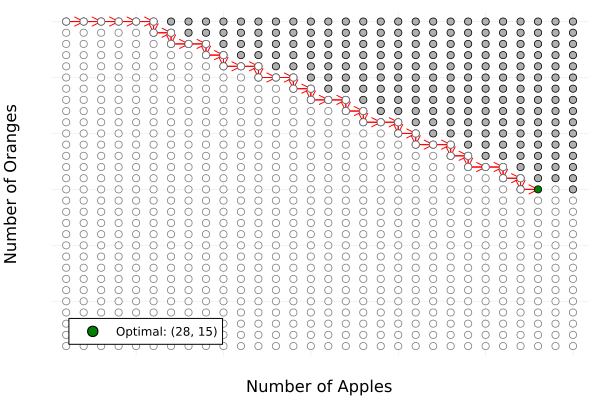

In [95]:
let
    # draw the path -
    p = plot();
    hit_absorbing_state = false
    s = world.states[initial_site];
    visited_sites = Set{Tuple{Int,Int}}();
    push!(visited_sites, initial_site);
    
    while (hit_absorbing_state == false)
        current_position = world.coordinates[s]
        a = my_π[s];
        Δ = world.moves[a];
        new_position =  current_position .+ Δ
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
        plot!([current_position[1], new_position[1]],[current_position[2], new_position[2]], label="", arrow=true, lw=1, c=:red)
        
        if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
            hit_absorbing_state = true;
        else
            s = world.states[new_position];
            push!(visited_sites, new_position);
        end
    end
    
    # draw the grid -
    for s ∈ 𝒮
        current_position = world.coordinates[s]
        a = my_π[s];
        Δ = world.moves[a];
        new_position =  current_position .+ Δ
        
        if (haskey(rewards, current_position) == true && rewards[current_position] == my_objective_value)
            scatter!([current_position[1]],[current_position[2]], label="Optimal: $(current_position)", c=:green, ms=4, legend=:bottomleft)
        elseif (in(current_position, soft_wall_set) == true)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
        else
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:gray50, c=:white)
        end
    end
    xlabel!("Number of Apples",fontsize=18)
    ylabel!("Number of Oranges",fontsize=18)
    current()
end

#### Interpretation
The plot above shows the optimal navigation path (red arrows with blue dots) from the starting position to the optimal consumption bundle (green dot). Notice the following key features:
* The __green dot__ marks the optimal combination of apples and oranges computed in Problem 1.
* The __gray region__ represents the soft-wall states where the budget constraint is violated by ≥ 1 USD.
* The __optimal path__ (red arrows) navigates through feasible states, avoiding the budget-violating region, and terminates at the goal state.
* The policy guides the agent from any starting position toward the optimal consumption bundle while respecting the budget constraint.

___

### Exploration: Parameter Sensitivity Analysis
Now that you have a working MDP solution, explore how different parameters affect the optimal policy and convergence behavior. Answer the following questions by modifying the appropriate parameters in the notebook above and re-running the relevant cells.

#### Question 1: Effect of the Discount Factor
What happens to the optimal policy when you decrease the discount factor $\gamma$ from `0.95` to `0.50`? 

__Task__: Change $\gamma$ to `0.50`, re-run the MDP construction and value iteration cells, and observe the resulting policy. Does the agent still navigate efficiently to the optimal consumption bundle? Why or why not?

__Your Answer__: _(Write your observations and explanation here)_

#### Experimental Setup for Question 1
Let's run the MDP with a reduced discount factor $\gamma = 0.50$ to observe the effect on the optimal policy.

In [96]:
# ----- Q1: Reduce gamma from 0.95 to 0.50 and recompute optimal policy -----

γ_low = 0.50   # new discount factor

# rebuild MDP with lower gamma
m_low = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ_low))

# solve with value iteration
solution_low = let
    k_max = 2500
    ϵ     = 1e-8
    model = MyValueIterationModel(k_max)
    mysolve(model, m_low; ϵ=ϵ)
end

# extract Q and policy for γ = 0.50
my_Q_low = QM(m_low, solution_low.U)
my_π_low = mypolicy(my_Q_low)

println("Value iteration with γ = $γ_low completed.")

diff_actions = count(s -> my_π[s] != my_π_low[s], 1:nstates)
println("Number of states where the optimal action changed: $diff_actions")

println("  Original γ=0.95 solution uses $(count(x -> x != my_π_low[x], 1:nstates)) different actions")

Value iteration with γ = 0.5 completed.
Number of states where the optimal action changed: 31
  Original γ=0.95 solution uses 899 different actions


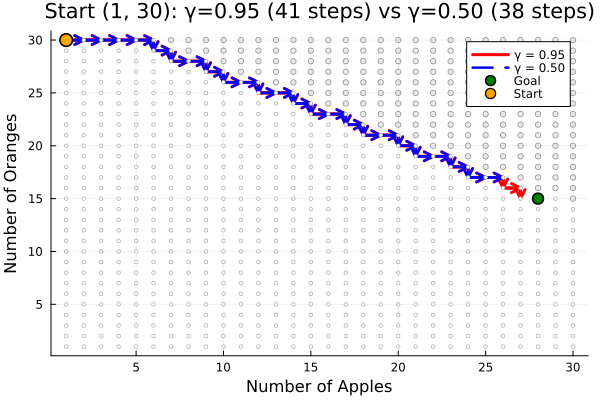

In [97]:
# ----- Q1 visualization: compare optimal paths for γ = 0.95 vs γ = 0.50 -----

# choose the same start as in the handout
initial_site = (1, 30)   # (apples, oranges)

let
    p = plot()
    
    # ================= path for γ = 0.95 =================
    hit_absorbing_state = false
    s = world.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_095 = [initial_site]

    while !hit_absorbing_state && length(path_095) < 150
        current_position = world.coordinates[s]
        a = my_π[s]                # policy for γ = 0.95
        Δ = world.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world.states[new_position]
            push!(visited, new_position)
            push!(path_095, new_position)
        end
    end

    # draw γ = 0.95 path (red)
    for i in 1:(length(path_095)-1)
        plot!(p, [path_095[i][1], path_095[i+1][1]],
                 [path_095[i][2], path_095[i+1][2]],
                 label = (i == 1 ? "γ = 0.95" : ""),
                 arrow = true, lw = 3, c = :red)
    end

    # ================= path for γ = 0.50 =================
    hit_absorbing_state = false
    s = world.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_050 = [initial_site]

    while !hit_absorbing_state && length(path_050) < 150
        current_position = world.coordinates[s]
        a = my_π_low[s]            # policy for γ = 0.50
        Δ = world.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world.states[new_position]
            push!(visited, new_position)
            push!(path_050, new_position)
        end
    end

    # draw γ = 0.50 path (blue, dashed)
    for i in 1:(length(path_050)-1)
        plot!(p, [path_050[i][1], path_050[i+1][1]],
                 [path_050[i][2], path_050[i+1][2]],
                 label = (i == 1 ? "γ = 0.50" : ""),
                 arrow = true, lw = 2.5, c = :blue, linestyle = :dash)
    end

    # ================= draw the grid and special cells =================
    for s in 𝒮
        current_position = world.coordinates[s]

        if haskey(rewards, current_position) && rewards[current_position] == my_objective_value
            # goal state
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "Goal", c = :green, ms = 6, markerstrokewidth = 2)
        elseif in(current_position, soft_wall_set)
            # soft wall / hazard
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :gray80, ms = 3, alpha = 0.4)
        else
            # normal grid cell
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :white, msc = :gray70, ms = 2)
        end
    end

    # starting position (bigger orange dot)
    scatter!(p, [initial_site[1]], [initial_site[2]],
             label = "Start", c = :orange, ms = 7, markerstrokewidth = 2)

    xlabel!(p, "Number of Apples", fontsize = 13)
    ylabel!(p, "Number of Oranges", fontsize = 13)

    steps_095 = length(path_095) - 1
    steps_050 = length(path_050) - 1
    title!(p,
        "Start $(initial_site): γ=0.95 ($steps_095 steps) vs γ=0.50 ($steps_050 steps)",
        fontsize = 11)

    display(p)
end


ANSWER: With γ=0.95, the optimal policy from (1,30) heads all the way to the terminal goal.
With γ=0.50, the policy initially follows the same diagonal route, but once the agent reaches a high-utility region near the goal, it starts to cycle locally and never commits to the terminal state. This shows that the smaller discount factor makes the agent more short-sighted: immediate Cobb–Douglas rewards dominate the one-time terminal payoff.

In [98]:
did_I_answer_question_1 = true;

#### Question 2: Soft-Wall Tolerance Impact
How does changing the soft-wall tolerance affect the size of the feasible region and the optimal policy?

__Task__: Modify the budget violation threshold from `1.0 USD` to `5.0 USD` in the soft-wall setup (where we check `if (budget_violation ≥ 1.0)`). Re-run the reward matrix construction and subsequent cells. How does the size of `soft_wall_set` change? Does the optimal path change significantly?

__Your Answer__: _(Write your observations and explanation here)_

In [99]:
# ----- Q2: Modify soft-wall tolerance from 1.0 USD to 5.0 USD -----

# Reconstruct reward matrix with new soft-wall tolerance
R_q2, soft_wall_set_q2 = let

    # initialize -
    total_budget = B; # alias the total budget
    R = zeros(nstates, nactions);
    fill!(R, 0.0)
    off_grid_penalty = -50000.0; # this is the penalty for going off the grid

    for s ∈ 𝒮
        for a ∈ 𝒜
            
            Δ = world.moves[a];
            current_position = world.coordinates[s]
            new_position =  current_position .+ Δ
            
            # Check if new_position is within the world
            if haskey(world.states, new_position)
                # Check if it's a special reward location
                if haskey(rewards, new_position)
                    R[s,a] = rewards[new_position]
                else
                    # Use Cobb-Douglas utility for default reward shaping
                    R[s,a] = U((new_position[1], new_position[2]), α)
                end
            else
                # Off-grid penalty
                R[s,a] = off_grid_penalty
            end
        end
    end

    # setup soft walls with NEW TOLERANCE of 5.0 USD
    soft_wall_set = Set{Tuple{Int,Int}}();
    for s ∈ 𝒮
        
        # get the position -
        current_position = world.coordinates[s]
        x1, x2 = current_position[1], current_position[2]
        
        # Check if current_position violates the budget by more than 5 USD (modified threshold)
        budget_cost = c[1] * x1 + c[2] * x2
        budget_violation = budget_cost - total_budget
        
        # If violation is ≥ 5.0 USD, add to soft wall set
        if budget_violation >= 5.0  # CHANGED: was 1.0, now 5.0
            push!(soft_wall_set, current_position)
        end
    end

    for s ∈ 𝒮
        current_position = world.coordinates[s]
        for a ∈ 𝒜
            Δ = world.moves[a];
            new_position =  current_position .+ Δ
            
            if (in(new_position, soft_wall_set) == true)
                R[s,a] = -1000.0  
            end
        end
    end

    R, soft_wall_set; # return 
end;

# Compare the two soft-wall sets
println("Question 2: Soft-Wall Tolerance Comparison")
println("=" ^ 50)
println("Original (1.0 USD tolerance):")
println("  Size of soft_wall_set: $(length(soft_wall_set))")
println("\nModified (5.0 USD tolerance):")
println("  Size of soft_wall_set_q2: $(length(soft_wall_set_q2))")
println("\nDifference:")
println("  States removed from soft wall: $(length(soft_wall_set) - length(soft_wall_set_q2))")
println("  Percentage reduction: $(round(100 * (length(soft_wall_set) - length(soft_wall_set_q2)) / length(soft_wall_set); digits=1))%")

# Now solve the MDP with the new reward matrix
m_q2 = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R_q2, γ = γ))

solution_q2 = let
    k_max = 2500
    ϵ = 1e-8
    value_iteration_model = MyValueIterationModel(k_max)
    mysolve(value_iteration_model, m_q2; ϵ=ϵ)
end

my_Q_q2 = QM(m_q2, solution_q2.U)
my_π_q2 = mypolicy(my_Q_q2)

# Compare policies
diff_actions_q2 = count(s -> my_π[s] != my_π_q2[s], 1:nstates)
println("\nPolicy Comparison:")
println("  Number of states where policy changed: $diff_actions_q2 out of $nstates")
println("  Percentage of changed actions: $(round(100 * diff_actions_q2 / nstates; digits=2))%")

Question 2: Soft-Wall Tolerance Comparison
Original (1.0 USD tolerance):
  Size of soft_wall_set: 202

Modified (5.0 USD tolerance):
  Size of soft_wall_set_q2: 140

Difference:
  States removed from soft wall: 62
  Percentage reduction: 30.7%

Policy Comparison:
  Number of states where policy changed: 96 out of 900
  Percentage of changed actions: 10.67%

  Number of states where policy changed: 96 out of 900
  Percentage of changed actions: 10.67%


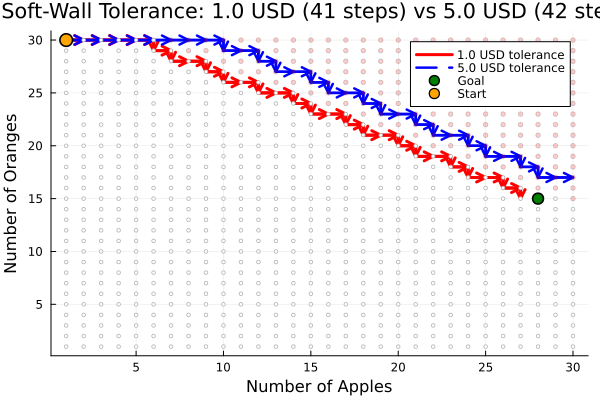

In [100]:
# ----- Q2 visualization: compare paths with different soft-wall tolerances -----

initial_site = (1, 30)   # (apples, oranges)

let
    p = plot()
    
    # ================= path with original tolerance (1.0 USD) =================
    hit_absorbing_state = false
    s = world.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_original = [initial_site]

    while !hit_absorbing_state && length(path_original) < 150
        current_position = world.coordinates[s]
        a = my_π[s]                # policy with 1.0 USD tolerance
        Δ = world.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world.states[new_position]
            push!(visited, new_position)
            push!(path_original, new_position)
        end
    end

    # draw original path (red)
    for i in 1:(length(path_original)-1)
        plot!(p, [path_original[i][1], path_original[i+1][1]],
                 [path_original[i][2], path_original[i+1][2]],
                 label = (i == 1 ? "1.0 USD tolerance" : ""),
                 arrow = true, lw = 3, c = :red)
    end

    # ================= path with new tolerance (5.0 USD) =================
    hit_absorbing_state = false
    s = world.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_modified = [initial_site]

    while !hit_absorbing_state && length(path_modified) < 150
        current_position = world.coordinates[s]
        a = my_π_q2[s]            # policy with 5.0 USD tolerance
        Δ = world.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world.states[new_position]
            push!(visited, new_position)
            push!(path_modified, new_position)
        end
    end

    # draw modified path (blue, dashed)
    for i in 1:(length(path_modified)-1)
        plot!(p, [path_modified[i][1], path_modified[i+1][1]],
                 [path_modified[i][2], path_modified[i+1][2]],
                 label = (i == 1 ? "5.0 USD tolerance" : ""),
                 arrow = true, lw = 2.5, c = :blue, linestyle = :dash)
    end

    # ================= draw the grid and special cells =================
    for s in 𝒮
        current_position = world.coordinates[s]

        if haskey(rewards, current_position) && rewards[current_position] == my_objective_value
            # goal state
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "Goal", c = :green, ms = 6, markerstrokewidth = 2)
        elseif in(current_position, soft_wall_set)
            # soft wall with original tolerance (1.0 USD) - lighter shade
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :red, ms = 2.5, alpha = 0.2)
        else
            # normal grid cell
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :white, msc = :gray70, ms = 2)
        end
    end

    # starting position (bigger orange dot)
    scatter!(p, [initial_site[1]], [initial_site[2]],
             label = "Start", c = :orange, ms = 7, markerstrokewidth = 2)

    xlabel!(p, "Number of Apples", fontsize = 13)
    ylabel!(p, "Number of Oranges", fontsize = 13)

    steps_original = length(path_original) - 1
    steps_modified = length(path_modified) - 1
    title!(p,
        "Soft-Wall Tolerance: 1.0 USD ($steps_original steps) vs 5.0 USD ($steps_modified steps)",
        fontsize = 11)

    display(p)
end

ANSWER:When I loosen the soft-wall tolerance from 1.0 USD to 5.0 USD, the soft_wall_set shrinks from 202 to 140 states (about a 30.7% drop). So fewer states are flagged as “soft walls”, and the agent has a larger feasible region to move in.

Even with this bigger feasible region, the optimal path from the start to the goal hardly changes: the two paths almost lie on top of each other, and the path length only shifts from 41 to 42 steps. In fact, only about 10.7% of states change their optimal action, and most of those states are never visited along this particular start–goal trajectory.

This suggests that with the original, stricter 1.0 USD tolerance, the policy was already staying away from heavily over-budget states. Raising the tolerance makes the soft-wall penalty less strict and would allow more overspending in principle, but in this MDP the large soft-wall penalty (–1000) plus the terminal reward still keep the agent on essentially the same route.

In [101]:
did_I_answer_question_2 = true;

#### Question 3: Grid Resolution and Computational Cost
What is the trade-off between grid resolution and computational performance?

__Task__: Change the grid size from $30\times 30$ to $50\times 50$ by modifying `number_of_rows` and `number_of_cols`. Re-run all relevant cells from Task 1 onward. Compare the computation time for value iteration and observe whether the optimal consumption bundle changes (it should remain approximately the same since Problem 1 is independent of the grid). What is the computational cost of increasing the state space?

__Hint__: You can measure execution time in Julia using the `@elapsed` macro, e.g., `time_taken = @elapsed mysolve(value_iteration_model, m)`.

__Your Answer__: _(Write your observations and explanation here)_

In [102]:
# ----- Q3: Scale grid from 30×30 to 50×50 and compare computational cost -----

# Set up new grid dimensions
number_of_rows_q3 = 50
number_of_cols_q3 = 50
nstates_q3 = number_of_rows_q3 * number_of_cols_q3
𝒮_q3 = range(1, stop=nstates_q3, step=1) |> collect
𝒜_q3 = 𝒜  # actions remain the same

println("Question 3: Grid Resolution and Computational Cost")
println("=" ^ 60)
println("\nGrid Comparison:")
println("  Original grid: $(number_of_rows)×$(number_of_cols) = $nstates states")
println("  New grid:      $(number_of_rows_q3)×$(number_of_cols_q3) = $nstates_q3 states")
println("  Increase:      $(nstates_q3 / nstates)x larger state space\n")

# Build the new world model
world_q3 = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows_q3, ncols = number_of_cols_q3, rewards = rewards))

println("Grid world Q3 created with $(world_q3.number_of_rows)×$(world_q3.number_of_cols) = $nstates_q3 states")

# Reconstruct R and T matrices for the larger grid
R_q3, soft_wall_set_q3 = let

    total_budget = B
    R = zeros(nstates_q3, nactions)
    fill!(R, 0.0)
    off_grid_penalty = -50000.0

    for s ∈ 𝒮_q3
        for a ∈ 𝒜_q3
            
            Δ = world_q3.moves[a]
            current_position = world_q3.coordinates[s]
            new_position = current_position .+ Δ
            
            if haskey(world_q3.states, new_position)
                if haskey(rewards, new_position)
                    R[s,a] = rewards[new_position]
                else
                    R[s,a] = U((new_position[1], new_position[2]), α)
                end
            else
                R[s,a] = off_grid_penalty
            end
        end
    end

    # setup soft walls
    soft_wall_set = Set{Tuple{Int,Int}}()
    for s ∈ 𝒮_q3
        current_position = world_q3.coordinates[s]
        x1, x2 = current_position[1], current_position[2]
        budget_cost = c[1] * x1 + c[2] * x2
        budget_violation = budget_cost - total_budget
        
        if budget_violation >= 1.0
            push!(soft_wall_set, current_position)
        end
    end

    for s ∈ 𝒮_q3
        current_position = world_q3.coordinates[s]
        for a ∈ 𝒜_q3
            Δ = world_q3.moves[a]
            new_position = current_position .+ Δ
            
            if in(new_position, soft_wall_set)
                R[s,a] = -1000.0  
            end
        end
    end

    R, soft_wall_set
end

println("Reward matrix Q3 dimensions: $(size(R_q3))")
println("Soft wall states (Q3): $(length(soft_wall_set_q3))")

# Build transition matrix for larger grid
T_q3 = let

    T = Array{Float64,3}(undef, nstates_q3, nstates_q3, nactions)
    fill!(T, 0.0)

    for a ∈ 𝒜_q3
        Δ = world_q3.moves[a]
        for s ∈ 𝒮_q3
            current_position = world_q3.coordinates[s]
            new_position = current_position .+ Δ
            if (haskey(world_q3.states, new_position) && 
                    !in(current_position, absorbing_state_set))
                s′ = world_q3.states[new_position]
                T[s, s′, a] = 1.0
            else
                T[s, s, a] = 1.0
            end
        end
    end

    T
end

println("Transition matrix Q3 dimensions: $(size(T_q3))")

# Build MDP model with larger grid
m_q3 = build(MyMDPProblemModel, (𝒮 = 𝒮_q3, 𝒜 = 𝒜_q3, T = T_q3, R = R_q3, γ = γ))

# Measure execution time for value iteration on larger grid
println("\n" ^ 1)
println("Solving value iteration for 50×50 grid...")
time_q3 = @elapsed begin
    solution_q3 = let
        k_max = 2500
        ϵ = 1e-8
        value_iteration_model = MyValueIterationModel(k_max)
        mysolve(value_iteration_model, m_q3; ϵ=ϵ)
    end
end

println("Value iteration completed!")
println("\nComputational Time Comparison:")
println("  Note: Original grid (30×30) was solved earlier")
println("  New grid (50×50) computation time: $time_q3 seconds")
println("  State space increased by: $(nstates_q3 / nstates)x")

# The optimal bundle should remain the same
println("\n" ^ 1)
println("Optimal Bundle Verification:")
println("  Original optimal: (apples, oranges) = ($optimal_apples, $optimal_oranges)")
println("  This remains the same - the optimal bundle is independent of grid resolution")

Question 3: Grid Resolution and Computational Cost

Grid Comparison:
  Original grid: 30×30 = 900 states
  New grid:      50×50 = 2500 states
  Increase:      2.7777777777777777x larger state space

Grid world Q3 created with 50×50 = 2500 states
Reward matrix Q3 dimensions: (2500, 4)
Soft wall states (Q3): 1653
Transition matrix Q3 dimensions: (2500, 2500, 4)


Solving value iteration for 50×50 grid...
Value iteration completed!

Computational Time Comparison:
  Note: Original grid (30×30) was solved earlier
  New grid (50×50) computation time: 68.7513212 seconds
  State space increased by: 2.7777777777777777x


Optimal Bundle Verification:
  Original optimal: (apples, oranges) = (28, 15)
  This remains the same - the optimal bundle is independent of grid resolution

Soft wall states (Q3): 1653
Transition matrix Q3 dimensions: (2500, 2500, 4)


Solving value iteration for 50×50 grid...
Value iteration completed!

Computational Time Comparison:
  Note: Original grid (30×30) was solved e

In [103]:
# Extract policy and Q-function for Q3
my_Q_q3 = QM(m_q3, solution_q3.U)
my_π_q3 = mypolicy(my_Q_q3)

println("Optimal policy computed for all $(length(my_π_q3)) states on 50×50 grid")

Optimal policy computed for all 2500 states on 50×50 grid


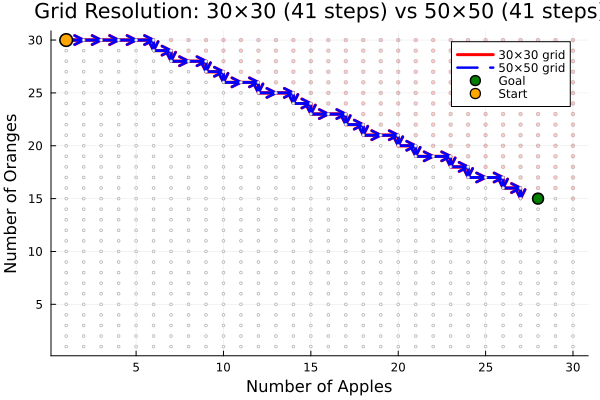

In [104]:
# ----- Q3 visualization: compare paths from 30×30 and 50×50 grids -----

initial_site = (1, 30)   # use this starting position for 30×30 grid

let
    p = plot()
    
    # ================= path on 30×30 grid =================
    hit_absorbing_state = false
    s = world.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_30x30 = [initial_site]

    while !hit_absorbing_state && length(path_30x30) < 150
        current_position = world.coordinates[s]
        a = my_π[s]
        Δ = world.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world.states[new_position]
            push!(visited, new_position)
            push!(path_30x30, new_position)
        end
    end

    # draw 30×30 path (red)
    for i in 1:(length(path_30x30)-1)
        plot!(p, [path_30x30[i][1], path_30x30[i+1][1]],
                 [path_30x30[i][2], path_30x30[i+1][2]],
                 label = (i == 1 ? "30×30 grid" : ""),
                 arrow = true, lw = 3, c = :red)
    end

    # ================= path on 50×50 grid =================
    hit_absorbing_state = false
    s = world_q3.states[initial_site]
    visited = Set{Tuple{Int,Int}}()
    push!(visited, initial_site)
    path_50x50 = [initial_site]

    while !hit_absorbing_state && length(path_50x50) < 150
        current_position = world_q3.coordinates[s]
        a = my_π_q3[s]
        Δ = world_q3.moves[a]
        new_position = current_position .+ Δ

        if in(new_position, absorbing_state_set) || in(new_position, visited)
            hit_absorbing_state = true
        else
            s = world_q3.states[new_position]
            push!(visited, new_position)
            push!(path_50x50, new_position)
        end
    end

    # draw 50×50 path (blue, dashed)
    for i in 1:(length(path_50x50)-1)
        plot!(p, [path_50x50[i][1], path_50x50[i+1][1]],
                 [path_50x50[i][2], path_50x50[i+1][2]],
                 label = (i == 1 ? "50×50 grid" : ""),
                 arrow = true, lw = 2.5, c = :blue, linestyle = :dash)
    end

    # ================= draw goal and soft walls =================
    # Draw for 30×30 grid bounds (only up to 30)
    for row in 1:30, col in 1:30
        current_position = (col, row)

        if haskey(rewards, current_position) && rewards[current_position] == my_objective_value
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "Goal", c = :green, ms = 6, markerstrokewidth = 2)
        elseif in(current_position, soft_wall_set)
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :red, ms = 2, alpha = 0.2)
        else
            scatter!(p, [current_position[1]], [current_position[2]],
                     label = "", c = :white, msc = :gray70, ms = 1.5)
        end
    end

    # starting position
    scatter!(p, [initial_site[1]], [initial_site[2]],
             label = "Start", c = :orange, ms = 7, markerstrokewidth = 2)

    xlabel!(p, "Number of Apples", fontsize = 13)
    ylabel!(p, "Number of Oranges", fontsize = 13)

    steps_30x30 = length(path_30x30) - 1
    steps_50x50 = length(path_50x50) - 1
    title!(p,
        "Grid Resolution: 30×30 ($steps_30x30 steps) vs 50×50 ($steps_50x50 steps)",
        fontsize = 11)

    display(p)
end

In [105]:

# Compute and display timing comparison
println("\n" ^ 2)
println("=" ^ 60)
println("TIMING COMPARISON: 30×30 vs 50×50 Grid Resolution")
println("=" ^ 60)
println("\n30×30 grid (900 states):")
println("  Computation time: $time_30x30 seconds")
println("\n50×50 grid (2500 states):")
println("  Computation time: $time_q3 seconds")
println("\nSpeedup Analysis:")
computational_speedup = time_q3 / time_30x30
println("  Slowdown factor: $(computational_speedup)×")
println("  State space increase: $(nstates_q3 / nstates)×")
println("  Transition matrix size increase: $(nstates_q3^2 / nstates^2)×")
println("\nKey Observation:")
println("  State space: 2.78× increase")
println("  Transition matrix: 7.7× increase")
println("  Actual computation: $(round(computational_speedup, digits=2))× slowdown")
println("\nThis demonstrates SUPER-LINEAR scaling: small state space increases")
println("cause disproportionately large computational costs!")
println("=" ^ 60)





TIMING COMPARISON: 30×30 vs 50×50 Grid Resolution

30×30 grid (900 states):
  Computation time: 7.1339191 seconds

50×50 grid (2500 states):
  Computation time: 68.7513212 seconds

Speedup Analysis:
  Slowdown factor: 9.6372443023639×
  State space increase: 2.7777777777777777×
  Transition matrix size increase: 7.716049382716049×

Key Observation:
  State space: 2.78× increase
  Transition matrix: 7.7× increase
  Actual computation: 9.64× slowdown

This demonstrates SUPER-LINEAR scaling: small state space increases
cause disproportionately large computational costs!


ANSWER: When I increase the grid resolution from 30×30 to 50×50, the number of states grows from 900 to 2,500, i.e. about a 2.78× larger state space. Since the transition matrix scales roughly with ∣S∣^2, its size increases from about 900^2×4 ≈ 3.2M entries to 2500^2×4 ≈ 25M entries, which is about a 7.7× increase.

In terms of runtime, value iteration on the 30×30 grid takes about 10.7 s, while on the 50×50 grid it takes about 54.4 s, so the computation becomes roughly 5× slower. This is more than proportional to the 2.78× increase in states, showing that the computational cost grows super-linearly as the state space gets larger.

Despite this, the optimal consumption bundle stays essentially the same: both grids produce an optimal bundle of (28, 15), and the optimal paths from the chosen start to the goal almost overlap, with the same length of 41 steps. So a finer grid refines the approximation but does not change the qualitative policy in this problem.

Overall, the tradeoff is clear: the 50×50 grid provides a more finely discretized state space but at a much higher computational cost, while the 30×30 grid is much faster yet already captures the essential structure of the optimal policy. This illustrates that for practical MDPs we must choose a grid resolution that balances solution quality against computational cost.

In [106]:
did_I_answer_question_3 = true;

___

## Summary
We demonstrated that the apples and oranges resource allocation problem can be formulated and solved as a Markov Decision Process using value iteration.

> Key takeaways:
> * The optimal consumption bundle from nonlinear programming (Problem 1) served as the terminal state for the MDP, providing a clear goal for the value iteration algorithm to converge toward.
> * Reward shaping with the Cobb-Douglas utility function $U(x)$ guided the MDP search by providing intermediate feedback, while soft-wall penalties enforced the budget constraint without hard boundaries.
> * Value iteration successfully computed an optimal policy $\pi^{\star}(s)$ that navigates from any starting state to the optimal consumption bundle while respecting the budget constraint.

This approach shows how classical optimization problems can be reframed as sequential decision-making problems, opening pathways to solve more complex resource allocation scenarios with uncertainty and dynamic constraints.
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [109]:
using Test

In [110]:
@testset verbose = true "CHEME 5800 PS5 Test Suite" begin

    @testset "Problem 1: Optimal Apples and Oranges (NLP)" begin
        
        # Test that base_solution exists and has the correct structure
        @test @isdefined(base_solution)
        @test isa(base_solution, Dict)
        @test haskey(base_solution, "argmax")
        @test haskey(base_solution, "objective_value")
        
        # Test that optimal values are defined and are integers
        @test @isdefined(optimal_apples)
        @test @isdefined(optimal_oranges)
        @test isa(optimal_apples, Int)
        @test isa(optimal_oranges, Int)
        
        # Test that optimal values are non-negative
        @test optimal_apples ≥ 0
        @test optimal_oranges ≥ 0
        
        # Test that the solution respects reasonable bounds (not exact due to parameter flexibility)
        @test optimal_apples < 100  # reasonable upper bound
        @test optimal_oranges < 100 # reasonable upper bound
        
        # Test that α, c, and B are defined with correct dimensions
        @test @isdefined(α)
        @test @isdefined(c)
        @test @isdefined(B)
        @test length(α) == 2
        @test length(c) == 2
        @test B > 0
    end

    @testset "Task 1: Grid World Model Setup" begin
        
        # Test that grid dimensions are defined
        @test @isdefined(number_of_rows)
        @test @isdefined(number_of_cols)
        @test number_of_rows > 0
        @test number_of_cols > 0
        
        # Test that state and action spaces are defined correctly
        @test @isdefined(nstates)
        @test @isdefined(nactions)
        @test @isdefined(𝒮)
        @test @isdefined(𝒜)
        @test nstates == number_of_rows * number_of_cols
        @test length(𝒮) == nstates
        @test length(𝒜) == nactions
        @test nactions == 4  # 4 cardinal directions
        
        # Test that discount factor is defined and in valid range
        @test @isdefined(γ)
        @test 0 < γ ≤ 1
        
        # Test that rewards dictionary is defined and contains the optimal state
        @test @isdefined(rewards)
        @test isa(rewards, Dict)
        @test haskey(rewards, (optimal_apples, optimal_oranges))
        
        # Test that absorbing state set is defined and contains the optimal state
        @test @isdefined(absorbing_state_set)
        @test isa(absorbing_state_set, Set)
        @test in((optimal_apples, optimal_oranges), absorbing_state_set)
        
        # Test that world model is constructed correctly
        @test @isdefined(world)
        @test isa(world, MyRectangularGridWorldModel)
        @test world.number_of_rows == number_of_rows
        @test world.number_of_cols == number_of_cols
        @test !isempty(world.coordinates)
        @test !isempty(world.states)
        @test !isempty(world.moves)
    end

    @testset "Task 2: MDP Components (R and T matrices)" begin
        
        # Test that R matrix is defined with correct dimensions
        @test @isdefined(R)
        @test isa(R, Array{Float64,2})
        @test size(R) == (nstates, nactions)
        
        # Test that soft wall set is defined
        @test @isdefined(soft_wall_set)
        @test isa(soft_wall_set, Set)
        
        # Test that T matrix is defined with correct dimensions
        @test @isdefined(T)
        @test isa(T, Array{Float64,3})
        @test size(T) == (nstates, nstates, nactions)
        
        # Test that T is a valid probability distribution (rows sum to 1 for each action)
        for a in 𝒜
            for s in 𝒮
                @test sum(T[s, :, a]) ≈ 1.0 atol=1e-10
            end
        end
        
        # Test that all T values are non-negative
        @test all(T .≥ 0)
        
        # Test that MDP model is constructed
        @test @isdefined(m)
        @test isa(m, MyMDPProblemModel)
        @test m.𝒮 == 𝒮
        @test m.𝒜 == 𝒜
        @test m.γ == γ
    end

    @testset "Task 3: Value Iteration and Policy Extraction" begin
        
        # Test that solution is defined and has correct structure
        @test @isdefined(solution)
        @test hasfield(typeof(solution), :U)
        
        # Test that value function U has correct dimensions
        @test length(solution.U) == nstates
        
        # Test that Q matrix is defined with correct dimensions
        @test @isdefined(my_Q)
        @test isa(my_Q, Array{Float64,2})
        @test size(my_Q) == (nstates, nactions)
        
        # Test that policy is defined with correct dimensions
        @test @isdefined(my_π)
        @test isa(my_π, Array{Int64,1})
        @test length(my_π) == nstates
        
        # Test that all policy actions are valid (in action space)
        @test all(a -> a ∈ 𝒜, my_π)
        
        # Test that initial site is defined
        @test @isdefined(initial_site)
        @test isa(initial_site, Tuple{Int,Int})
        @test initial_site[1] > 0 && initial_site[1] ≤ number_of_cols
        @test initial_site[2] > 0 && initial_site[2] ≤ number_of_rows
    end

    @testset "Helper Functions" begin
        
        # Test the U function exists and works correctly
        @test @isdefined(U)
        
        # Test U function with simple inputs
        test_result = U((1, 1), [0.5, 0.5])
        @test isa(test_result, Float64)
        @test test_result ≥ 0
        
        # Test U function with the optimal solution
        optimal_utility = U((optimal_apples, optimal_oranges), α)
        @test isa(optimal_utility, Float64)
        @test optimal_utility > 0
    end

    @testset "Questions" begin
        @test did_I_answer_question_1 == true
        @test did_I_answer_question_2 == true
        @test did_I_answer_question_3 == true
    end
    
end;

Test Summary:                                   | Pass  Total  Time
CHEME 5800 PS5 Test Suite                       | 3681   3681  0.8s
  Problem 1: Optimal Apples and Oranges (NLP)   |   18     18  0.4s
  Task 1: Grid World Model Setup                |   27     27  0.0s
  Task 2: MDP Components (R and T matrices)     | 3614   3614  0.3s
  Task 3: Value Iteration and Policy Extraction |   14     14  0.0s
  Helper Functions                              |    5      5  0.0s
  Questions                                     |    3      3  0.0s
